In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread, imshow, imsave
import cv2
import numpy as np
from skimage.metrics import structural_similarity as compare_ssim
import imutils

#### **Read the Image**
The image read below consists of a bunch of shapes for which we will find the contours. 

In [2]:
referenceimage_database=[]

In [3]:
def read_file(file_path):
    img = imread(file_path)
    return img

def display_image(img,title='Image'):
    plt.figure(figsize=[10,10])
    channels=len(img.shape)
    if channels<3:
        plt.imshow(img,cmap='Greys_r');
    else:
        plt.imshow(img);      
    plt.title(title);plt.axis("off");
    
def resize_image(img,scale_percent):
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized_img
    
def plot_histogram(img):
    colors = ("red", "green", "blue")
    channel_ids = (0, 1, 2)

    plt.figure()
    plt.xlim([0, 256])
    for channel_id, c in zip(channel_ids, colors):
        histogram, bin_edges = np.histogram(
            img[:, :, channel_id], bins=256, range=(0, 256)
        )
        plt.plot(bin_edges[0:-1], histogram, color=c)

    plt.title("Color Histogram")
    plt.xlabel("Color value")
    plt.ylabel("Pixel count")
    
def grayscale_conversion(img):
    channels=len(img.shape)
    if channels<3:
        return img
    grayscale_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return grayscale_image

def smooth_image(img,kernel_size):
    smooth_image = cv2.GaussianBlur(img,(kernel_size,kernel_size),0)
    return smooth_image

In [4]:
def mark_object_boundary(img):
    smoothed=smooth_image(img,5)
    smoothed_gray=grayscale_conversion(smoothed)
    
    ret, thresh = cv2.threshold(smoothed_gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1)
    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=1)
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.06*dist_transform.max(),255,0)
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0
    our_img=img.copy()
    markers = cv2.watershed(our_img,markers)
    our_img[markers == -1] = [255,255,255]
    return our_img

def draw_contour_rectangles(org_img,img,color_set=(0,0,255),width=1):
    img=grayscale_conversion(img)
    
    cnts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    count=0
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        count+=1
        cv2.rectangle(org_img, (x, y), (x+w+2, y+h+2),color_set, width)
    return org_img,count

def select_referenceimage(img):
    return 0
    
    

def detect_draw_contours(img):
    smoothed=smooth_image(img,5)
    smoothed_gray=grayscale_conversion(smoothed)
    binary = cv2.adaptiveThreshold(smoothed_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV, 11, 17)
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_copy = img.copy()
    cv2.drawContours(img_copy, contours, -1, (255, 255, 255), 2)
    return img_copy

In [5]:
def isFaulty_referencebased(image_path,display=[0,0,0,1]):

    image_stack=[]
    orginal_image=read_file(image_path)
    image_stack.append(orginal_image)

    ref_image=read_file('rep.jpeg')
#     ref_image=select_referenceimage(orginal_image)
    image_stack.append(ref_image)

    scale_percent = 90 # percent of original size

    resized_o_image = resize_image(orginal_image,scale_percent)
    resized_r_image = resize_image(ref_image,scale_percent)

    grayscale_o_image=grayscale_conversion(resized_o_image)
    grayscale_r_image=grayscale_conversion(resized_r_image)   # hard-coded reference image

    
    blurred_o_image =smooth_image(grayscale_o_image,3)
    blurred_r_image =smooth_image(grayscale_r_image,3)

    threshold1,segmented_o_image = cv2.threshold(blurred_o_image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    threshold2,segmented_r_image = cv2.threshold(blurred_r_image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # comaprison with reference
    (score, diff) = compare_ssim(segmented_o_image, segmented_r_image, full=True)
    diff = (diff*255).astype("uint8")
    image_stack.append(diff)
    
    thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    kernel = np.ones((3, 3), np.uint8)
    img_erosion = cv2.erode(thresh, kernel, iterations=3)
    
    defect_localized,count=draw_contour_rectangles(resized_o_image,img_erosion)
    image_stack.append(defect_localized)    
    for x in range(4):
        if display[x]==1:
            display_image(image_stack[x])
    return count>=2

In [6]:
def isFaulty_contourbased(file_path,display=[0,0,0,0]):
    image_stack=[]
    scale_percent = 90 # percent of original size
    my_image=resize_image(read_file(file_path),scale_percent)
    image_stack.append(my_image)
    boundary_image=mark_object_boundary(my_image)
    contour_based_image=detect_draw_contours(my_image)
    image_stack.append(boundary_image)
    image_stack.append(contour_based_image)
    diff = grayscale_conversion(boundary_image)-grayscale_conversion(contour_based_image)
    
    kernel_5 = np.ones((5, 5), np.uint8)
    kernel_2 = np.ones((2, 2), np.uint8)
    kernel = np.full(fill_value=1/(6*6*250), shape=(6,16), dtype=float)
    conv_diff = cv2.filter2D(diff,-1,kernel)
    
    conv_diff = cv2.erode(conv_diff, kernel_5, iterations=1)
    erroded_diff = cv2.erode(conv_diff, kernel_2, iterations=1)

    cnts = cv2.findContours(erroded_diff,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    img=my_image.copy()
    count=0
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        if w and h in range(10,50):
            count+=1
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 1)
    image_stack.append(img)
    for x in range(4):
        if display[x]==1:
            display_image(image_stack[x])
    return count>3

False

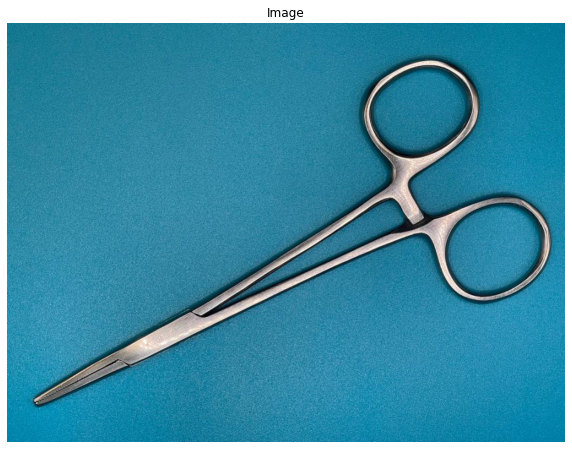

In [9]:
isFaulty_contourbased('C:/Users/saqib/OneDrive/Desktop/defects_data/ (9).jpeg',[1,0,0,0])

True

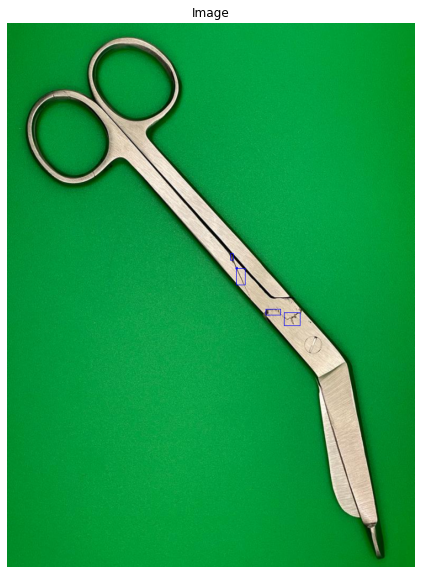

In [8]:
isFaulty_referencebased('defected (1).jpeg')